# Model_1_Pose_Estimation_ResNet

# Introduction



Source: https://satyajitghana.medium.com/human-pose-estimation-and-quantization-of-pytorch-to-onnx-models-a-detailed-guide-b9c91ddc0d9f

Dataset: http://human-pose.mpi-inf.mpg.de/

Metric: https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/README.md

# Preparing the Model

In [ ]:
! git clone https://github.com/microsoft/human-pose-estimation.pytorch && cd human-pose-estimation.pytorch && git checkout 18f1d0fa5b5db7fe08de640610f3fdbdbed8fb2f

Cloning into 'human-pose-estimation.pytorch'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 197 (delta 1), reused 7 (delta 0), pack-reused 188
Receiving objects: 100% (197/197), 73.71 KiB | 563.00 KiB/s, done.
Resolving deltas: 100% (87/87), done.
Note: switching to '18f1d0fa5b5db7fe08de640610f3fdbdbed8fb2f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 18f1d0f Update README.md


In [ ]:
pip install onnx onnxruntime==1.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
import sys
if "/content/human-pose-estimation.pytorch/lib/" not in sys.path:
    sys.path.insert(0, "/content/human-pose-estimation.pytorch/lib/")

In [ ]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.transforms as T

import cv2

import re
import os
import copy
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
import models
from core.config import config
from core.config import update_config
from core.config import update_dir
from core.config import get_model_name

We are going to use MPII - ResNet50 Model trained on `256x256` sized images
model_file: https://drive.google.com/file/d/1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc/view?usp=sharing

In [ ]:
! gdown https://drive.google.com/uc?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc

Downloading...
From (original): https://drive.google.com/uc?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc
From (redirected): https://drive.google.com/uc?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc&confirm=t&uuid=1b71a686-00d4-4bc4-a556-6d6fa15588d8
To: /content/pose_resnet_50_256x256.pth.tar
100% 136M/136M [00:04<00:00, 30.6MB/s]


The corresponding config file is taken from experiments folder

In [ ]:
CONFIG_FILE = '/content/human-pose-estimation.pytorch/experiments/mpii/resnet50/256x256_d256x3_adam_lr1e-3.yaml'
MODEL_PATH = '/content/pose_resnet_50_256x256.pth.tar'

In [ ]:
#update_config(CONFIG_FILE)
#config.GPUS = '' # we are running on CPU

Load the model

In [ ]:
model = eval('models.'+config.MODEL.NAME+'.get_pose_net')(config, is_train=False)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
from torchsummary import summary

In [ ]:
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
model

PoseResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [ ]:
# Iterate through each layer and print its details
for name, layer in model.named_children():
    print(f'Layer Name: {name.ljust(20)} | Type: {layer.__class__.__name__.ljust(20)} | Parameters: {sum(p.numel() for p in layer.parameters())}')
print('-'*50)
print(f'Total Parameters: {sum(p.numel() for p in model.parameters())}')

Layer Name: conv1                | Type: Conv2d               | Parameters: 9408
Layer Name: bn1                  | Type: BatchNorm2d          | Parameters: 128
Layer Name: relu                 | Type: ReLU                 | Parameters: 0
Layer Name: maxpool              | Type: MaxPool2d            | Parameters: 0
Layer Name: layer1               | Type: Sequential           | Parameters: 215808
Layer Name: layer2               | Type: Sequential           | Parameters: 1219584
Layer Name: layer3               | Type: Sequential           | Parameters: 7098368
Layer Name: layer4               | Type: Sequential           | Parameters: 14964736
Layer Name: deconv_layers        | Type: Sequential           | Parameters: 10487296
Layer Name: final_layer          | Type: Conv2d               | Parameters: 4112
--------------------------------------------------
Total Parameters: 33999440


# Using the Model

In [ ]:
!wget https://raw.githubusercontent.com/Abyza/Project_Exercise_Posture_Correction/main/Creation_of_Models/Sample_Images/paulo3.png


--2024-05-17 21:37:39--  https://raw.githubusercontent.com/Abyza/Project_Exercise_Posture_Correction/main/Creation_of_Models/Sample_Images/paulo3.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100891 (99K) [image/png]
Saving to: ‘paulo3.png’

paulo3.png          100%[===================>]  98.53K  --.-KB/s    in 0.08s   

2024-05-17 21:37:40 (1.22 MB/s) - ‘paulo3.png’ saved [100891/100891]



In [ ]:
IMAGE_FILE = 'paulo3.png'

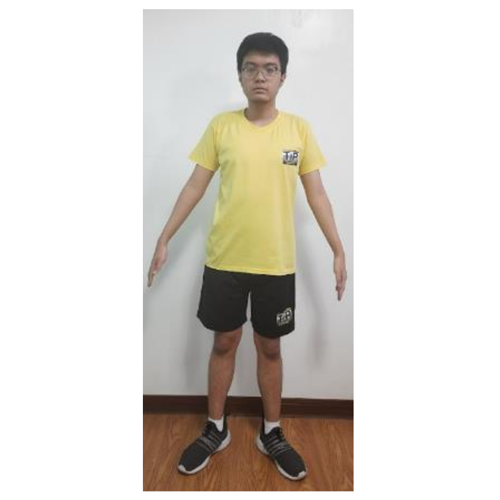

In [ ]:
image = Image.open(IMAGE_FILE)
image = image.convert('RGB')
image

In [ ]:
transform = T.Compose([
                       T.Resize((256, 256)),
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                       ])

Transform the image for the model

In [ ]:
tr_img = transform(image)

In [ ]:
tr_img.shape
# index position 1 is the y axis

torch.Size([3, 256, 256])

Pass the Image through the model

In [ ]:
output = model(tr_img.unsqueeze(0))
output = output.squeeze(0)

In [ ]:
output.shape

torch.Size([16, 64, 64])

In [ ]:
_, OUT_HEIGHT, OUT_WIDTH = output.shape
output.shape

torch.Size([16, 64, 64])

In [ ]:
get_detached = lambda x: copy.deepcopy(x.cpu().detach().numpy())

In [ ]:
get_detached

<function __main__.<lambda>(x)>

`joint_id` - name
taken from: http://human-pose.mpi-inf.mpg.de/#download

In [ ]:
JOINTS = ['0 - r ankle', '1 - r knee', '2 - r hip', '3 - l hip', '4 - l knee', '5 - l ankle', '6 - pelvis', '7 - thorax', '8 - upper neck', '9 - head top', '10 - r wrist', '11 - r elbow', '12 - r shoulder', '13 - l shoulder', '14 - l elbow', '15 - l wrist']
JOINTS = [re.sub(r'[0-9]+|-', '', joint).strip().replace(' ', '-') for joint in JOINTS]

In [ ]:
POSE_PAIRS = [
# UPPER BODY
              [9, 8],
              [8, 7],
              [7, 6],

# LOWER BODY
              [6, 2],
              [2, 1],
              [1, 0],

              [6, 3],
              [3, 4],
              [4, 5],

# ARMS
              [7, 12],
              [12, 11],
              [11, 10],

              [7, 13],
              [13, 14],
              [14, 15]
]

In [ ]:
from operator import itemgetter
get_keypoints = lambda pose_layers: map(itemgetter(1, 3), [cv2.minMaxLoc(pose_layer) for pose_layer in pose_layers])

In [ ]:
get_keypoints

<function __main__.<lambda>(pose_layers)>

Here are all the detections

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)


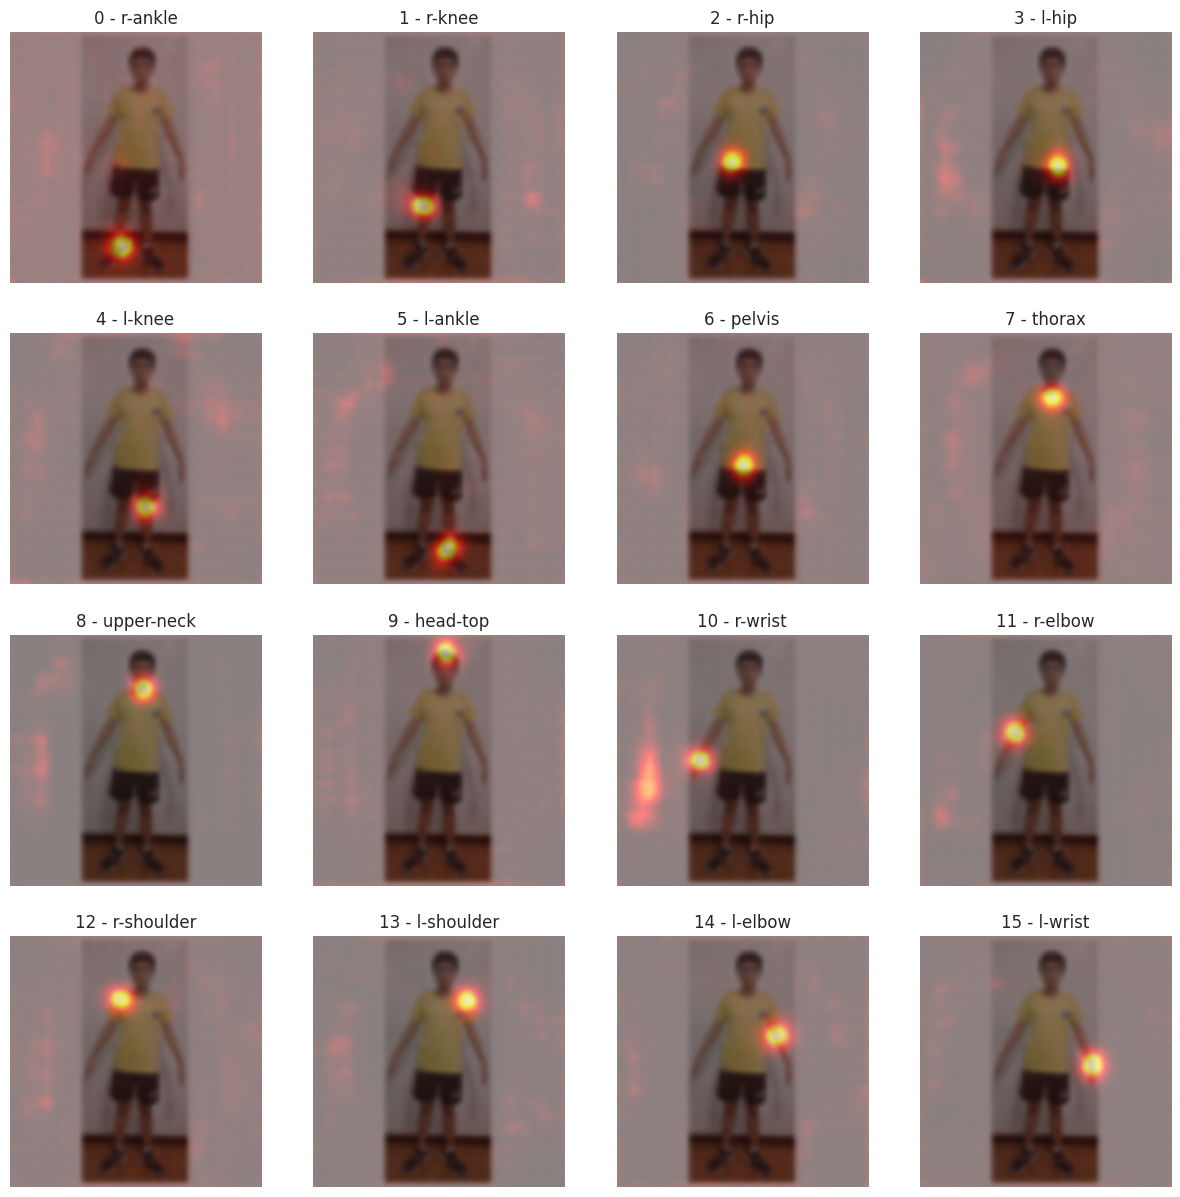

In [ ]:
plt.figure(figsize=(15, 15))
for idx, pose_layer in enumerate(get_detached(output)):
    # print(pose_layer.shape)
    plt.subplot(4, 4, idx + 1)
    plt.title(f'{idx} - {JOINTS[idx]}')
    plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='hot', interpolation='bicubic')
    print(pose_layer.shape)
    plt.imshow(pose_layer, alpha=0.5, cmap='hot', interpolation='bicubic')
    plt.axis('off')
plt.show()

Here are the detections summarised in a single image

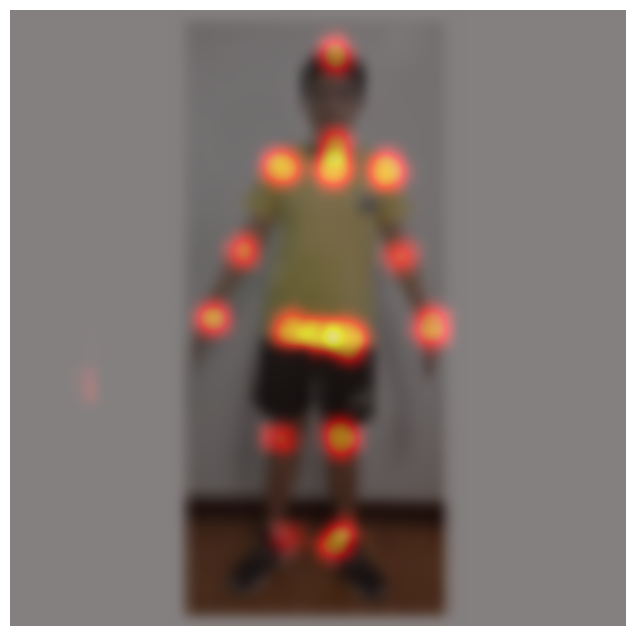

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='hot', interpolation='bicubic')
pose_layers = get_detached(output)
pose_layers = np.clip(pose_layers, 0.5, 1.0)
layer_sum = np.sum(pose_layers, axis=0)
plt.imshow(layer_sum, alpha=0.5, cmap='hot', interpolation='bicubic')
plt.axis('off')
plt.show()

Now we will connect these detected regions

In [ ]:
THRESHOLD = 0.5
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = cv2.imread(IMAGE_FILE)
pose_layers = get_detached(x=output)
key_points = list(get_keypoints(pose_layers=pose_layers))
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]

    IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        # this is the point in the head the very top just 1 point
        # color is in BGR
        cv2.ellipse(image_p, (from_x_j, from_y_j), (7, 7), 0, 0, 360, (245, 10, 178), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        # this is all the other point except the head
        cv2.ellipse(image_p, (to_x_j, to_y_j), (7, 7), 0, 0, 360, (245, 10, 178), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (250, 150, 35), 3)

### Our final image with the estimated pose !

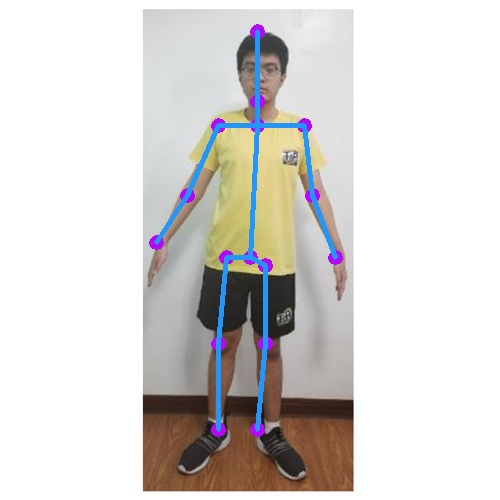

In [ ]:
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))

In [ ]:
# Convert BGR image to RGB format
rgb_image = cv2.cvtColor(image_p, cv2.COLOR_BGR2RGB)

# Create PIL Image object from RGB array
pil_image = Image.fromarray(rgb_image)

# Save the PIL Image to a file (e.g., 'output_image.jpg')
output_file_path = 'output_points_lines.jpg'
pil_image.save(output_file_path)

print(f"Image saved to {output_file_path}")

Image saved to output_points_lines.jpg


# Converting the Model

In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def print_size_of_onnx_model(model):
    onnx.save(model, 'temp.onnx')
    print('Size (MB):', os.path.getsize("temp.onnx")/1e6)
    os.remove('temp.onnx')

PyTorch Model Size

In [ ]:
print_size_of_model(model)

Size (MB): 136.303756


In [ ]:
new_model = copy.deepcopy(model)

Now we will Convert this model to ONNX

In [ ]:
import io
import numpy as np
import torch.onnx

In [ ]:
# Input to the model
torch_model = new_model
batch_size = 1
x = torch.randn(batch_size, 3, 256, 256, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "model_1_post_estimation_resnet.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

In [ ]:
import onnx

onnx_model = onnx.load("model_1_post_estimation_resnet.onnx")
onnx.checker.check_model(onnx_model)

Let's just check the size of the saved ONNX Model

In [ ]:
print_size_of_onnx_model(onnx_model)

Size (MB): 135.924959


In [ ]:
# Load the ONNX model
onnx_model = onnx.load('/content/model_1_post_estimation_resnet.onnx')

# Display the inputs of the model
print("Inputs:")
for input in onnx_model.graph.input:
    print(input.name, input.type)

# Display the outputs of the model
print("\nOutputs:")
for output in onnx_model.graph.output:
    print(output.name, output.type)

# Display the layers of the model
print("\nLayers:")
for node in onnx_model.graph.node:
    print(node.op_type, node.name)

Inputs:
input tensor_type {
  elem_type: 1
  shape {
    dim {
      dim_param: "batch_size"
    }
    dim {
      dim_value: 3
    }
    dim {
      dim_value: 256
    }
    dim {
      dim_value: 256
    }
  }
}


Outputs:
output tensor_type {
  elem_type: 1
  shape {
    dim {
      dim_param: "batch_size"
    }
    dim {
      dim_value: 16
    }
    dim {
      dim_value: 64
    }
    dim {
      dim_value: 64
    }
  }
}


Layers:
Conv /conv1/Conv
Relu /relu/Relu
MaxPool /maxpool/MaxPool
Conv /layer1/layer1.0/conv1/Conv
Relu /layer1/layer1.0/relu/Relu
Conv /layer1/layer1.0/conv2/Conv
Relu /layer1/layer1.0/relu_1/Relu
Conv /layer1/layer1.0/conv3/Conv
Conv /layer1/layer1.0/downsample/downsample.0/Conv
Add /layer1/layer1.0/Add
Relu /layer1/layer1.0/relu_2/Relu
Conv /layer1/layer1.1/conv1/Conv
Relu /layer1/layer1.1/relu/Relu
Conv /layer1/layer1.1/conv2/Conv
Relu /layer1/layer1.1/relu_1/Relu
Conv /layer1/layer1.1/conv3/Conv
Add /layer1/layer1.1/Add
Relu /layer1/layer1.1/relu_2/Relu
Co

And also lets quicky test if the model works

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("model_1_post_estimation_resnet.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tr_img.unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)

In [ ]:
ort_outs = ort_outs[0][0]

In [ ]:
len(ort_outs)

16

# Testing the Converted Model

In [ ]:
import onnx

def check_layers_and_weights(onnx_model):
    # Number of layers
    num_layers = len(onnx_model.graph.node)

    # Number of weights
    num_weights = len(onnx_model.graph.initializer)

    if num_layers > 0 and num_weights > 0:
        print("The ONNX model contains both layers and weights.")
    elif num_layers > 0:
        print("The ONNX model contains only layers (no weights).")
    elif num_weights > 0:
        print("The ONNX model contains only weights (no layers).")
    else:
        print("The ONNX model contains neither layers nor weights.")

    print("Number of layers:", num_layers)
    print("Number of weights:", num_weights)

# Load the ONNX model
onnx_model = onnx.load('/content/model_1_post_estimation_resnet.onnx')

# Check layers and weights
check_layers_and_weights(onnx_model)

The ONNX model contains both layers and weights.
Number of layers: 129
Number of weights: 123


In [ ]:
import onnx
import onnxruntime as ort
import numpy as np

# Load the ONNX model
onnx_model = onnx.load('model_1_post_estimation_resnet.onnx')

# Create an ONNX runtime inference session
session = ort.InferenceSession('model_1_post_estimation_resnet.onnx')

# Get the input name of the model
input_name = session.get_inputs()[0].name

# Define the input shape
input_shape = (1, 3, 256, 256)

# Generate sample input data
input_data = np.random.rand(*input_shape).astype(np.float32)

# Perform inference
output = session.run(None, {input_name: input_data})

# Print the output
print(output)

[array([[[[ 1.33087961e-02,  1.32950181e-02,  7.39084091e-03, ...,
           6.83344621e-03,  1.19538186e-02,  3.71237937e-03],
         [ 4.73505817e-04,  1.19853588e-02,  6.09711464e-03, ...,
           3.83607019e-03, -2.76802387e-03,  6.29029516e-03],
         [ 2.20477954e-03,  9.60264076e-03,  1.48870889e-03, ...,
           3.91695742e-03,  8.63589067e-03,  2.59590149e-03],
         ...,
         [ 1.13942195e-03,  3.87913827e-03,  5.16527332e-04, ...,
           4.72236518e-03,  3.76888551e-04,  2.41573621e-03],
         [ 5.27612027e-03,  3.09562031e-03,  9.10484232e-04, ...,
           5.44934440e-03,  6.87272195e-03,  6.73681218e-03],
         [ 2.35217027e-02,  9.07410588e-03, -3.67670413e-03, ...,
           4.34768666e-03, -4.69419267e-03,  6.29844610e-03]],

        [[ 1.34244552e-02,  6.59703277e-03,  1.01377992e-02, ...,
           1.28833195e-02,  7.66853243e-03,  1.16924634e-02],
         [ 2.81892065e-03,  8.34624190e-03, -9.59828496e-04, ...,
           8.23689345

In [ ]:
import onnx
import onnxruntime as ort
import numpy as np
import time

def inference_onnx_model(model_path, input_shape):
    # Load the ONNX model
    onnx_model = onnx.load(model_path)

    # Create an ONNX runtime inference session
    session = ort.InferenceSession(model_path)

    # Get the input name of the model
    input_name = session.get_inputs()[0].name

    # Generate sample input data
    input_data = np.random.rand(*input_shape).astype(np.float32)

    # Perform inference and measure execution time
    start_time = time.time()
    output = session.run(None, {input_name: input_data})
    end_time = time.time()

    # Calculate execution time
    execution_time = end_time - start_time

    return output, execution_time

# Example usage:
model_path = 'model_1_post_estimation_resnet.onnx'
input_shape = (1, 3, 256, 256)

output, execution_time = inference_onnx_model(model_path, input_shape)
print("Execution time:", execution_time, "seconds")


Execution time: 0.22200727462768555 seconds


In [ ]:
import numpy as np

# Define the number of tests
num_tests = 100

# Initialize an empty list to store execution times
execution_times = []

# Run the function multiple times
for _ in range(num_tests):
    output, execution_time = inference_onnx_model(model_path, input_shape)
    execution_times.append(execution_time)

# Calculate the average execution time
average_execution_time = np.mean(execution_times)

print("Average execution time over", num_tests, "tests:", average_execution_time, "seconds")


Average execution time over 100 tests: 0.265809862613678 seconds


In [ ]:
output[0].shape

(1, 16, 64, 64)

# Summary

Residual Network

| ResNet_256_50               | Model #1         |
|-----------------------------|------------------|
| mAP (Mean Average Precision)| 88.5             |
| Time on Laptop CPU          | 0.0333 sec       |
| Time on Google Collab CPU   | 0.2658 sec       |
| Number of layers            | 129              |
| Number of weights           | 123              |
| Onnx Model Size             | 132.7 mb         |
| Input shape                 | (1, 3, 256, 256) |
| Output shape                | (1, 16, 64, 64)  |
| # of Keypoints              | 16               |

Google Collab Link:

https://colab.research.google.com/drive/1qYauRwFmWnHw4fhkCy9wY7mhp3SBjk6M?usp=sharing